In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation, Reshape, Dropout, Flatten, Lambda
from keras.layers import Conv2DTranspose, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, UpSampling2D, UpSampling1D 
from keras.layers import LocallyConnected1D, LocallyConnected2D, LSTM, RepeatVector
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils, plot
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils, plot

In [4]:
n = 2
dim4 = True
multiTrack = True
context, x_train, labels = data.import_data(data.init(), n, dim4=dim4, multiTrack=multiTrack)

Setting up params

max min f 25.0 0.5
 >> Context(max_t=2.0, dt=0.02, n_instances=100, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Importing midi-data

 [INFO] : 
 |  reading file: ../datasets/examples/simple-straight-120.mid
 [INFO] : 
 |  reading file: ../datasets/examples/simple-shuffle-120.mid

Encoding midi-data
 [<midi file '../datasets/examples/simple-straight-120.mid' type 0, 1 tracks, 68 messages>, <midi file '../datasets/examples/simple-shuffle-120.mid' type 0, 1 tracks, 68 messages>]
> -> multi-track = True
 [INFO] : 
 |  reduced dims:
 |  (2, 100, 1)


In [ ]:
n = 1000
min_f = -4 # normalized to 0
max_f = 4
x_train, params = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f,
    n_polyrythms=2,
    n_channels=4,
    d_phase=False,
    return_params=True,
    dim4=dim4,
    multiTrack=multiTrack)

In [ ]:
x_train.shape

In [ ]:
m = int(x_train.shape[0] * 0.9)
[x_train.shape, m]

In [ ]:
x_test = x_train[m:]
x_train = x_train[:m]

In [ ]:
plot.single(x_train[0, :50,:,0])
plot.single(x_train[1, :50,:,0])
plot.single(x_train[2, :50,:,0])

In [ ]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

In [ ]:
latent_dim = 2
intermediate_dim = 128
epsilon_std = 1.0

In [19]:
def encoder(input_size, dropout=0.1):
    encoder_input = Input(shape=input_size)
    
    # Convolve & Pool
    h = encoder_input
    h = Reshape(input_shape[:-1])(h)
    h = Conv1D(32, kernel_size=2, strides=2, activation='relu', padding='same')(h)
    h = Conv1D(32, kernel_size=2, strides=1, activation='relu', padding='same')(h)
    h = Conv1D(64, kernel_size=2, strides=2, activation='relu', padding='same')(h)
    h = Conv1D(64, kernel_size=2, strides=1, activation='relu', padding='same')(h)
    #     x = AveragePooling2D((2, 2))(x)
    h = Conv1D(128, kernel_size=2, strides=2, activation='relu', padding='same')(h)

    # Dense layers
    h = Dropout(dropout)(h) # uncomment when using larger batches
    h = Flatten()(h)
    h = Dense(intermediate_dim, activation='relu')(h)
    # h = Dense(intermediate_dim, activation='relu', kernel_regularizer=k_reg, activity_regularizer=a_reg)(h)
    
#     x = Reshape((-1, 1, 1))(x)

    h = Reshape((-1, intermediate_dim))(h)
    n_capsules = 10
    capsule_dim = 10
    n_routings = 3
    share_weights = True
    h = Capsule(n_capsules, capsule_dim, n_routings, share_weights)(h)

    # h = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(h)
    h = Reshape((n_capsules * capsule_dim,))(h)
    
    # Z Mean, Variance - no activation? TODO
    z_mean = Dense(latent_dim, name='z_mean')(h) # , activation='relu'
    z_log_var = Dense(latent_dim, name='z_log_var')(h) # , activation='relu'

    encoder_output = [z_mean, z_log_var]
    encoder_model = Model(encoder_input, encoder_output, name='encoder_model-')
    return encoder_model, encoder_input, z_mean, z_log_var

In [20]:
encoder_model, encoder_input, z_mean, z_log_var = encoder(input_shape)
encoder_model.summary()

shared weights, shape = (1, 128, 100) 12800
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 2, 1)    0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 100, 2)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 50, 32)       160         reshape_1[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 50, 32)       2080        conv1d_1[0][0]                   
_________________________________________________________________

In [21]:
sample_ = lambda args: models.sample(args, z_mean, z_log_var, latent_dim, epsilon_std)

In [22]:
# z = Lambda(sampling)([z_mean, z_log_var])
z_input = encoder_model(encoder_input)
z_output = Lambda(sample_)(z_input)

In [23]:
def list_decoders(output_shape, p='valid'):
    # decoder_input = z_output
    # h = decoder_input
    # :output_shape = (timesteps, channels, channels) || (batches, filters, timesteps, channels)
    # keras offers just Conv2DTranspose and not Conv1DTranspose
    # - use 2D images during upsampling :: (timesteps, notes, channels) => (timesteps, notes, filters)
    # - use 1D images to optimize reconstruction :: (timesteps, filters) => (timesteps, notes)
    
    # image_data_format = 'channels_last'
    # goal shape: (timesteps, notes, channels)
    # start with the 'reverse': lots of small imgs => few large img
    
    timesteps, notes, channels = output_shape
    m = 4 # multiplier for dims
    
    # at the start of upsampling, the image-structure does not yet have to correspond to the goal structure 
    # ?TODO use y*y*y starting dims, may conv, and only then correct the structure (?)
    output_shape = (timesteps, notes, channels)
    
    # we instantiate these layers separately so as to reuse them later
    decoders = []
    decoders += [ Dense(intermediate_dim, activation='relu') ]
    decoders += [ Dense(intermediate_dim * 2, activation='relu') ]
    decoders += [ Dense(np.prod(output_shape), activation='relu') ]
#     decoders += [ Reshape(output_shape[-3:]) ]
    
    # Convolution
    # Note that the kernel windows do not yet correspond to 'temporal' features, but rather to just spatial features
    k = (3,2) # (2,1) :: (timesteps, notes)
    s = (1,3)
    timesteps_ = int(timesteps / 2)
    
#     decoders += [ Conv2DTranspose(timesteps_, kernel_size=k, strides=3, activation='relu', padding=p) ]
#     decoders += [ Conv2DTranspose(32, kernel_size=k, strides=3, activation='relu', padding=p) ]
#    # decoder += [Conv2DTranspose(32, kernel_size=k, strides=3, activation='relu', padding=p)]
#     decoders += [ Conv2DTranspose(16, kernel_size=k, strides=(3,1), activation='relu', padding=p)]
#     decoders += [ Conv2DTranspose(16, kernel_size=k, strides=3, activation='relu', padding=p)]
    
    # 'end' of upsampling
#     decoders += [ Conv2D(1, kernel_size=(1,2), strides=1, activation='relu', padding=p) ]
    # shape = ()
    # decoder_reshape2 = Reshape(dims[0:2])
    # #     h = Conv1D(16, kernel_size=2, strides=1, activation='relu', padding=p)(h)
    # decoder_conv2 = Conv1D(notes * m, kernel_size=2, strides=2, activation='relu', padding=p)
    
    
    # Mean (output)
    # h = Conv2D(1, kernel_size=1, strides=s, activation='sigmoid', padding='same')(h)
    output_shape = (timesteps, notes, channels)
    
#     decoders += [ Flatten()]
    decoders += [ Dense(np.prod(output_shape), activation='sigmoid')]
    decoders += [ Reshape(output_shape)]
    return decoders

In [24]:
decoders = list_decoders(input_shape)

In [25]:
decoded = utils.composition(decoders, z_output, verbose=False)

In [26]:
# instantiate VAE model
vae_input = encoder_input
vae_output = decoded
vae = Model(vae_input, vae_output)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 2, 1)    0                                            
__________________________________________________________________________________________________
encoder_model- (Model)          [(None, 2), (None, 2 257492      input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 2)            0           encoder_model-[1][0]             
                                                                 encoder_model-[1][1]             
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          384         lambda_2[0][0]                   
__________

In [27]:
# Compute VAE loss
def vae_loss(beta=1.):
    # y_true, y_pred, z_mean, z_log_var, timesteps=150, notes=3, beta=1.
    xent_loss = timesteps * notes * keras.metrics.binary_crossentropy(K.flatten(vae_input), K.flatten(vae_output))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

vae_loss = vae_loss()
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
# vae.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Output "reshape_4" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "reshape_4" during training.
  # This is added back by InteractiveShellApp.init_path()


In [28]:
# train the VAE on MNIST digits
# (x_train, _), (x_test, y_test) = mnist.load_data()

In [29]:
x_train.shape

(900, 100, 2, 1)

In [30]:
print('x_train.shape:', x_train.shape)

x_train.shape: (900, 100, 2, 1)


In [31]:
batch_size = 100
epochs = 50
params = {'batch_size': batch_size, 'return_y': False}

In [32]:
# phase_mod = 0.1
# whitening = False

# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by dataset std
#         samplewise_std_normalization=False,  # divide each input by its std
# #         zca_epsilon=10,
#         zca_whitening=whitening,
#         rotation_range=0,  # randomly rotate images in 0 to 180 degrees
#         width_shift_range=0.,  # note-channel mod, but not shuffled
#         height_shift_range=phase_mod,  # start_t, phase
#         horizontal_flip=False,  # reverse
#         vertical_flip=False)

# # datagen.fit(x_train)

In [33]:
x_train.shape

(900, 100, 2, 1)

In [34]:
useDataGenerator = False
# useDataGenerator = True

print('batch_size =', batch_size)
if useDataGenerator:
    datagen = models.ImageDataGenerator(x_train, batch_size)
    history = collections.defaultdict(list)
    n_batches = datagen.__len__()
    for e in range(epochs):
        print('[Epoch %i]' % e)
        for batch_i, (x_batch, y_batch) in enumerate(datagen.flow(x_train, x_train, batch_size)):
            print(' Batch %i/%i' % (batch_i,n_batches))
            x = datagen.shuffle_3rd_dim(x_batch)
            h = vae.fit(x, verbose=1)
            for k,v in h.history.items(): 
                history[k].append(v)
            if batch_i >= n_batches:
                break
#     history = vae.fit_generator(
#         X, epochs=epochs, steps_per_epoch=X.__len__(),
#         use_multiprocessing=True, workers=2,
#         validation_data=(x_test, None))
else:
    h = vae.fit(x_train, epochs=epochs, validation_data=(x_test, None))
    history = h.history

batch_size = 100
Train on 900 samples, validate on 100 samples
Epoch 1/50
900/900 [==============================] - 1s 1ms/step - loss: 88.2226 - val_loss: 77.2640
Epoch 2/50
900/900 [==============================] - 1s 743us/step - loss: 75.5850 - val_loss: 74.3666
Epoch 3/50
900/900 [==============================] - 1s 645us/step - loss: 73.0963 - val_loss: 72.9151
Epoch 4/50
900/900 [==============================] - 1s 723us/step - loss: 72.6136 - val_loss: 73.4020
Epoch 5/50
900/900 [==============================] - 1s 795us/step - loss: 72.6104 - val_loss: 73.1016
Epoch 6/50
900/900 [==============================] - 1s 817us/step - loss: 72.5476 - val_loss: 72.8893
Epoch 7/50
900/900 [==============================] - 1s 626us/step - loss: 72.4868 - val_loss: 73.9433
Epoch 8/50
900/900 [==============================] - 1s 706us/step - loss: 72.4759 - val_loss: 72.3851
Epoch 9/50
900/900 [==============================] - 1s 651us/step - loss: 72.4626 - val_loss: 73.0978
Epo

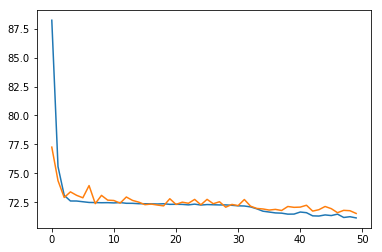

In [35]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

m (50, 2)


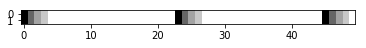

m (50, 2)


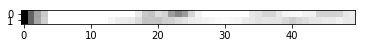

In [36]:
i = 0
x = vae.predict(x_train[:10])
plot.single(x_train[i, :50, :, 0])
plot.single(x[i, :50, :, 0])

In [37]:
x.shape

(10, 100, 2, 1)

m (30, 2)


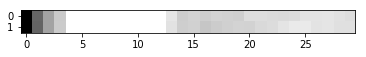

In [38]:
# interpolate - mean
m = x.mean(axis=0)
plot.single(m[:30,:,0])

m (30, 2)


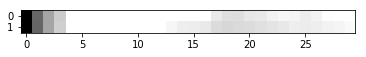

In [39]:
# interpolate - min: these pixels are 'always' active
m = x.min(axis=0)
plot.multi(m[:30,:,0])

In [40]:
# build a model to project inputs on the latent space
encoder = Model(encoder_input, z_mean)

In [41]:
x_test.shape

(100, 100, 2, 1)

In [42]:
m = 100
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(100, 2)

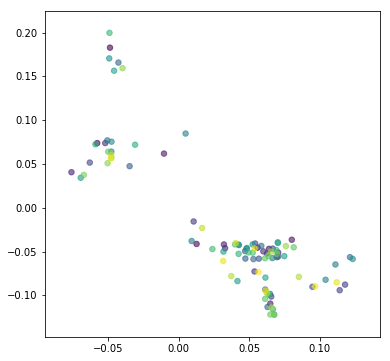

In [46]:
# y_test = range(x_train_encoded.shape[0])
y_test = np.concatenate([list(range(n)) for _ in range(int(m/n)+1)])[:m] / n
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], c=y_test, alpha=0.6, s=30)

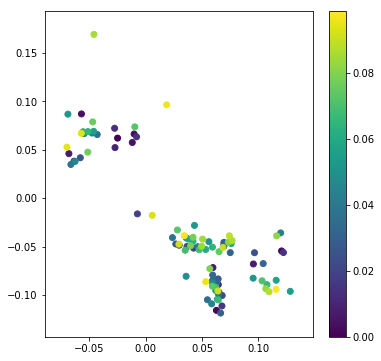

In [44]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [ ]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_decoded = utils.composition(decoders, decoder_input, verbose=False)
generator = Model(decoder_input, _decoded)

In [ ]:
# x_decoded[0].reshape(150,3)

In [ ]:
# display a 2D manifold of the digits
n = 3  # figure with 15x15 digits
digit_size1 = x_decoded.shape[-2]
digit_size2 = x_decoded.shape[-1]
figure = np.zeros((digit_size1 * n, digit_size1 * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = generator.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size1, digit_size2)
        figure[i * digit_size1: (i + 1) * digit_size1,
               j * digit_size2: (j + 1) * digit_size2] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()